## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1 - Load data from file
f_name = "~/data/data_000637.txt"
data = pd.read_csv(f_name, nrows = 20**4, dtype=np.int)
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


In [134]:
# 2 - Find value of x
counter = data.loc[:,['BX_COUNTER']]
x = int(counter.max() + 1)
print('x =',x)

x = 3564


In [143]:
# 3 - Find out duration time
def compute_time(sample):
    result = sample['ORBIT_CNT'].iloc[0]*x*25 + sample['TDC_MEAS'].iloc[0]*25/30 + sample['BX_COUNTER'].iloc[0]*25
    return result

# Search fisrt sample, data is ot ordered
smallest_orbit = data[data['ORBIT_CNT'] <= data['ORBIT_CNT'].min()]
smallest_bx = smallest_orbit[smallest_orbit['BX_COUNTER'] <= smallest_orbit['BX_COUNTER'].min()]
first_sample = smallest_bx[smallest_bx['TDC_MEAS'] <= smallest_bx['TDC_MEAS'].min()]
time_first_sample = compute_time(first_sample)

# Search fisrt sample, data is ot ordered
biggest_orbit = data[data['ORBIT_CNT'] >= data['ORBIT_CNT'].max()]
biggest_bx = biggest_orbit[biggest_orbit['BX_COUNTER'] >= biggest_orbit['BX_COUNTER'].max()]
last_sample = biggest_bx[biggest_bx['TDC_MEAS'] >= biggest_bx['TDC_MEAS'].max()]
time_last_sample = compute_time(last_sample)

# Compute total time
total_time = time_last_sample - time_first_sample
print("Total time (ns):", total_time)

Total time (ns): 141841007.5


In [144]:
# 4 - Add new column 
data['TIME_NS'] = data['ORBIT_CNT']*x*25 + data['TDC_MEAS']*25/30 + data['BX_COUNTER']*25
# recompute the duration time
duration = data['TIME_NS'].max()-data['TIME_NS'].min()
print('Total time (ns):', duration)

Total time (ns): 141841007.5


In [145]:
# 5 - Replace values of column HEAD
k = np.random.randint(0, 2)
data['HEAD'] = pd.DataFrame(np.random.randint(0,2,data.shape[0]))

In [147]:
# 6 - Create new DataFrame
data_new = data[data['HEAD']>0]
data_new.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
1,1,0,124,3869200167,2374,27,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14


<Figure size 432x288 with 0 Axes>

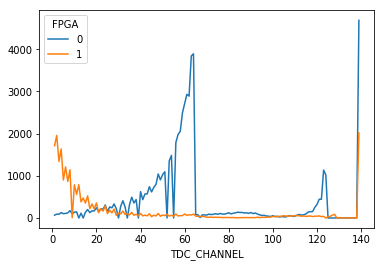

In [157]:
# 7 - Plot FPGA
FPGA_0 = data_new[data_new['FPGA']<1]
FPGA_1 = data_new[data_new['FPGA']>0]

plt.figure()
# Sum all columns, but we are only interested in the sum of HEAD column, which conteins all 1
data_group = data_new.groupby(['FPGA','TDC_CHANNEL']).sum() 
# unstack columns
data_plot = data_group.unstack('FPGA')['HEAD'].fillna(value=0)
data_plot.plot()
plt.show()

In [199]:
# 8 - Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)
num = 3
data_channel = data_new.groupby(['FPGA','TDC_CHANNEL']).sum()
noisy = pd.DataFrame([data_channel['HEAD'].nlargest(num).index]).T # (FPGA,TDC_CHANNEL)
noisy

,0
0,"(0, 139)"
1,"(0, 64)"
2,"(0, 63)"


In [200]:
# 9 - Count the number of unique orbits. Count the number of unique orbits with at least one measurement 
# from TDC_CHANNEL=139

orb = data_new.groupby('ORBIT_CNT').sum()['HEAD']

# Search unique orbits
unique = orb[orb == 1] 
print('Unique obits:', unique.sum())

# Uniques from 139
orbit_139 = data_new[data_new['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').sum()['HEAD']
unique_139 = orbit_139[orbit_139 == 1] 
print('Unique obits from 139:',unique_139.sum())

Unique obits: 1
Unique obits from 139: 123
